In [29]:
class ModelConfig:
    TRAIN_DATASET_PATH ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    TEST_DATASET_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
    SINGLE_TEST_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036"
    BATCH_SIZE = 1
    EPOCHS = 10
    MODEL_WEIGHTS_DIRECTORY = "/content/drive/MyDrive/Dataset/UCSD/Train"
    COMBINE_MODEL_PATH = "GAN_combine_model.hdf5"
    GENERATOR_MODEL_PATH = "GAN_generator_model.hdf5"
    DISCRIMINATOR_MODEL_PATH = "GAN_discriminator_model.hdf5"
    AUTOENCODER_MODEL_PATH = "autoencoder_model.hdf5"
    SEQUENCE_SIZE = 10
    H = 227
    W = 227
    C = 1
    TO_GRAY = True
    STRIDE = range(1, 3)
    TRAIN_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Train/npys"
    TEST_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Test/npys"



In [30]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Activation, TimeDistributed,
                                     BatchNormalization, Conv3D, Conv2D, 
                                     LeakyReLU, Conv3DTranspose, Conv2DTranspose,
                                     ConvLSTM2D, LayerNormalization)
from tensorflow.keras.layers import MaxPool3D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


def encoder(X_input):
    # encoder    
    X = Conv3D(32, 3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)

    X = Conv3D(48, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)

    X = Conv3D(64, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)
    # current shape is 2x16x16x64
    X = Conv3D(64, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    bottleneck = MaxPool3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same')(X)
    
    return bottleneck

    
def decoder(bottleneck):    
    X = Conv3DTranspose(48, 2, strides=(2, 2, 2), padding='valid', name="decoder_layer")(bottleneck)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 4x32x32x48
    X = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 8x64x64x32
    X = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 16x128x128x32
    X = Conv3D(ModelConfig.C, 3, strides=(1, 1, 1), padding='same')(X)
    X = Activation('sigmoid')(X)

    return X

def AutoEncoderModel(X_input):
    autoencoder = Model(X_input, decoder(encoder(X_input)), name='AutoEncoderModel')
    return autoencoder


def custom_loss(new, original):
    reconstruct_loss = K.mean(K.square(new-original))
    return reconstruct_loss

X_input = Input(shape=(ModelConfig.SEQUENCE_SIZE, ModelConfig.H,ModelConfig.W,ModelConfig.C))
autoEncoderModel = AutoEncoderModel(X_input)
opt = keras.optimizers.Adam(learning_rate=0.001)
autoEncoderModel.compile(
    loss=custom_loss, optimizer=opt, metrics=['accuracy'])

print(autoEncoderModel.summary())

Model: "AutoEncoderModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 227, 227, 1)  0         
                             ]                                   
                                                                 
 conv3d_55 (Conv3D)          (None, 10, 227, 227, 32)  896       
                                                                 
 batch_normalization_56 (Bat  (None, 10, 227, 227, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 10, 227, 227, 32)  0         
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 5, 113, 113, 32)  0         
 g3D)                                                            
                                                  

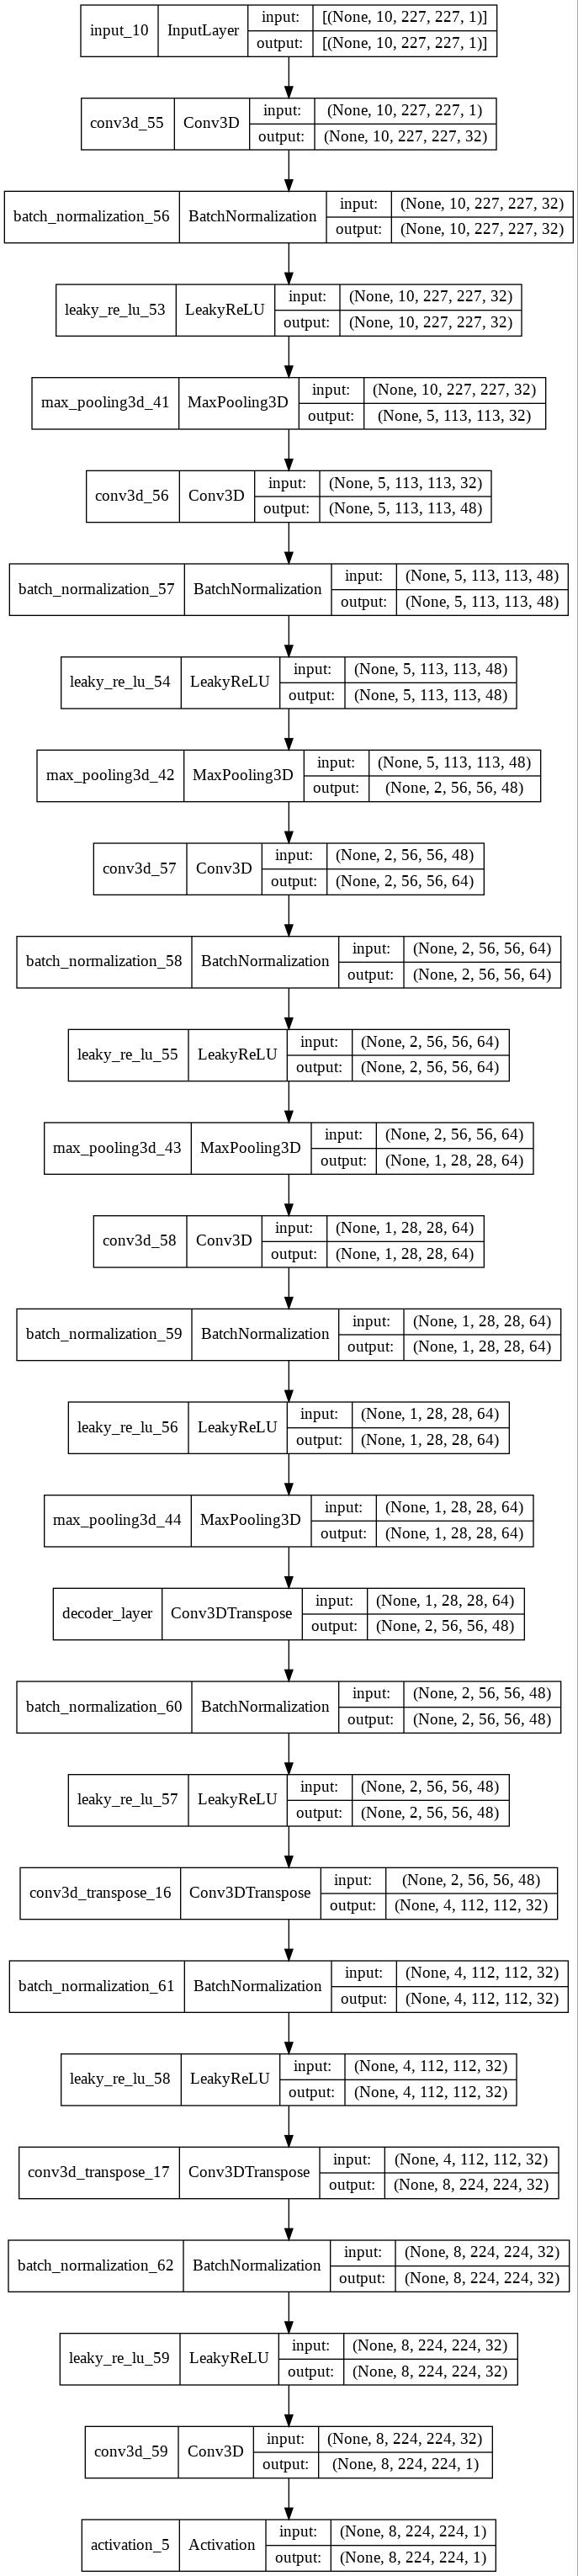

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(autoEncoderModel, to_file='auto_encoder_Non_lstm_plot.jpg', show_shapes=True, show_layer_names=True)

In [32]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Activation, TimeDistributed,
                                     BatchNormalization, Conv3D, Conv2D, 
                                     LeakyReLU, Conv3DTranspose, Conv2DTranspose,
                                     ConvLSTM2D, LayerNormalization)
from tensorflow.keras.layers import MaxPool3D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K



from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose, Input, Lambda
from keras.models import Sequential

def build_model1(optimizer="adam", loss="mse", reload_model=True):
    
  if not reload_model:
    return load_model(Config.MODEL_PATH)

  model=Sequential()

  model.add(Input((ModelConfig.H,ModelConfig.W,ModelConfig.SEQUENCE_SIZE,ModelConfig.C)))

  model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

  model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

  model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

  model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))

  model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

  model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

  model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

  model.compile(optimizer=optimizer,loss=loss)

  return model

autoEncoderModel = build_model1(optimizer="adam", loss="mse", reload_model=True)

print(autoEncoderModel.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 57, 57, 10, 128)   15616     
                                                                 
 conv3d_61 (Conv3D)          (None, 29, 29, 10, 64)    204864    
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 29, 29, 10, 64)    295168    
                                                                 
 conv_lstm2d_10 (ConvLSTM2D)  (None, 29, 29, 10, 32)   110720    
                                                                 
 conv_lstm2d_11 (ConvLSTM2D)  (None, 29, 29, 10, 64)   221440    
                                                                 
 conv3d_transpose_18 (Conv3D  (None, 58, 58, 10, 128)  204928    
 Transpose)                                                      
                                                      

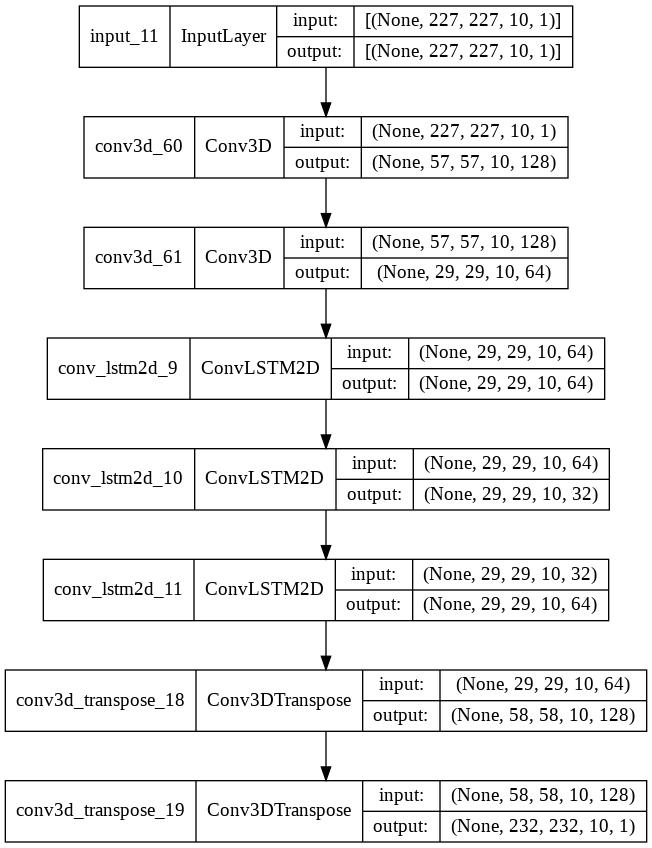

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(autoEncoderModel, to_file='auto_encoder_lstm_plot.jpg', show_shapes=True, show_layer_names=True)

In [34]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Activation, TimeDistributed,
                                     BatchNormalization, Conv3D, Conv2D, 
                                     LeakyReLU, Conv3DTranspose, Conv2DTranspose,
                                     ConvLSTM2D, LayerNormalization)
from tensorflow.keras.layers import MaxPool3D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


def encoder(X_input):
    # encoder    
    X = Conv3D(32, 3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)

    X = Conv3D(48, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)

    X = Conv3D(64, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid')(X)
    # current shape is 2x16x16x64
    X = Conv3D(64, 3, padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    bottleneck = MaxPool3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same')(X)
    
    return bottleneck

    
def decoder(bottleneck):    
    X = Conv3DTranspose(48, 2, strides=(2, 2, 2), padding='valid', name="decoder_layer")(bottleneck)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 4x32x32x48
    X = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 8x64x64x32
    X = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    # current shape is 16x128x128x32
    X = Conv3D(ModelConfig.C, 3, strides=(1, 1, 1), padding='same')(X)
    X = Activation('sigmoid')(X)

    return X

def AutoEncoderModel(X_input):
    autoencoder = Model(X_input, decoder(encoder(X_input)), name='AutoEncoderModel')
    return autoencoder


def custom_loss(new, original):
    reconstruct_loss = K.mean(K.square(new-original))
    return reconstruct_loss

X_input = Input(shape=(16, 128,128,3))
autoEncoderModel = AutoEncoderModel(X_input)
opt = keras.optimizers.Adam(learning_rate=0.001)
autoEncoderModel.compile(
    loss=custom_loss, optimizer=opt, metrics=['accuracy'])
print(autoEncoderModel.summary())

Model: "AutoEncoderModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 16, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d_62 (Conv3D)          (None, 16, 128, 128, 32)  2624      
                                                                 
 batch_normalization_63 (Bat  (None, 16, 128, 128, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 16, 128, 128, 32)  0         
                                                                 
 max_pooling3d_45 (MaxPoolin  (None, 8, 64, 64, 32)    0         
 g3D)                                                            
                                                  

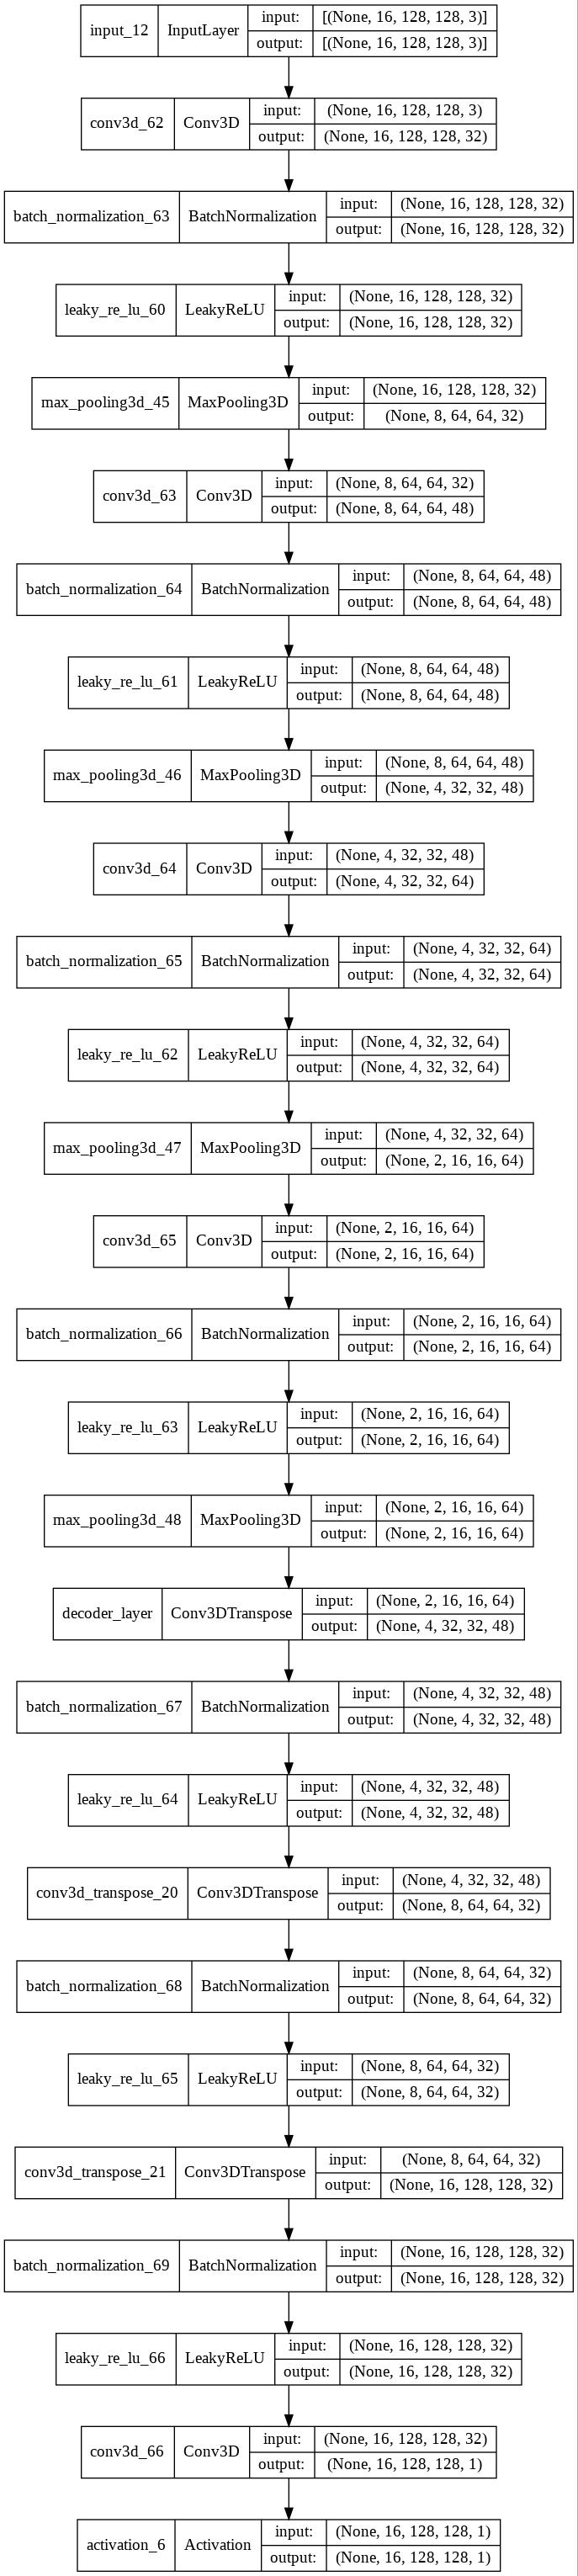

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(autoEncoderModel, to_file='gan_generator_plot.jpg', show_shapes=True, show_layer_names=True)

In [36]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv3D,ConvLSTM2D, Flatten, Dense, Input,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

def create_discriminator_model():    
    
    model = Sequential()
    
    model.add(Input((16,128,128,3)))
    model.add(Conv3D(32, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid'))
    
    model.add(Conv3D(48, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid'))

    model.add(Conv3D(64, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid'))
    
    model.add(Conv3D(64, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))
    
    model.add(Conv3D(32, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))
    
    model.add(Conv3D(16, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# def DiscriminatorModel(X_input):
#     discriminator = Model(X_input, create_discriminator_model(X_input), name='Discriminator')
#     return discriminator

#X_input = Input(shape=(ModelConfig.H,ModelConfig.W,ModelConfig.SEQUENCE_SIZE,ModelConfig.C))
discriminator = create_discriminator_model()
opt = Adam(lr=0.001)
loss = BinaryCrossentropy()
discriminator.compile(loss=loss,
                      optimizer=opt,
                      metrics=['accuracy'])
print(discriminator.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_67 (Conv3D)          (None, 16, 128, 128, 32)  2624      
                                                                 
 batch_normalization_70 (Bat  (None, 16, 128, 128, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 16, 128, 128, 32)  0         
                                                                 
 max_pooling3d_49 (MaxPoolin  (None, 8, 64, 64, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_68 (Conv3D)          (None, 8, 64, 64, 48)     41520     
                                                                 
 batch_normalization_71 (Bat  (None, 8, 64, 64, 48)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


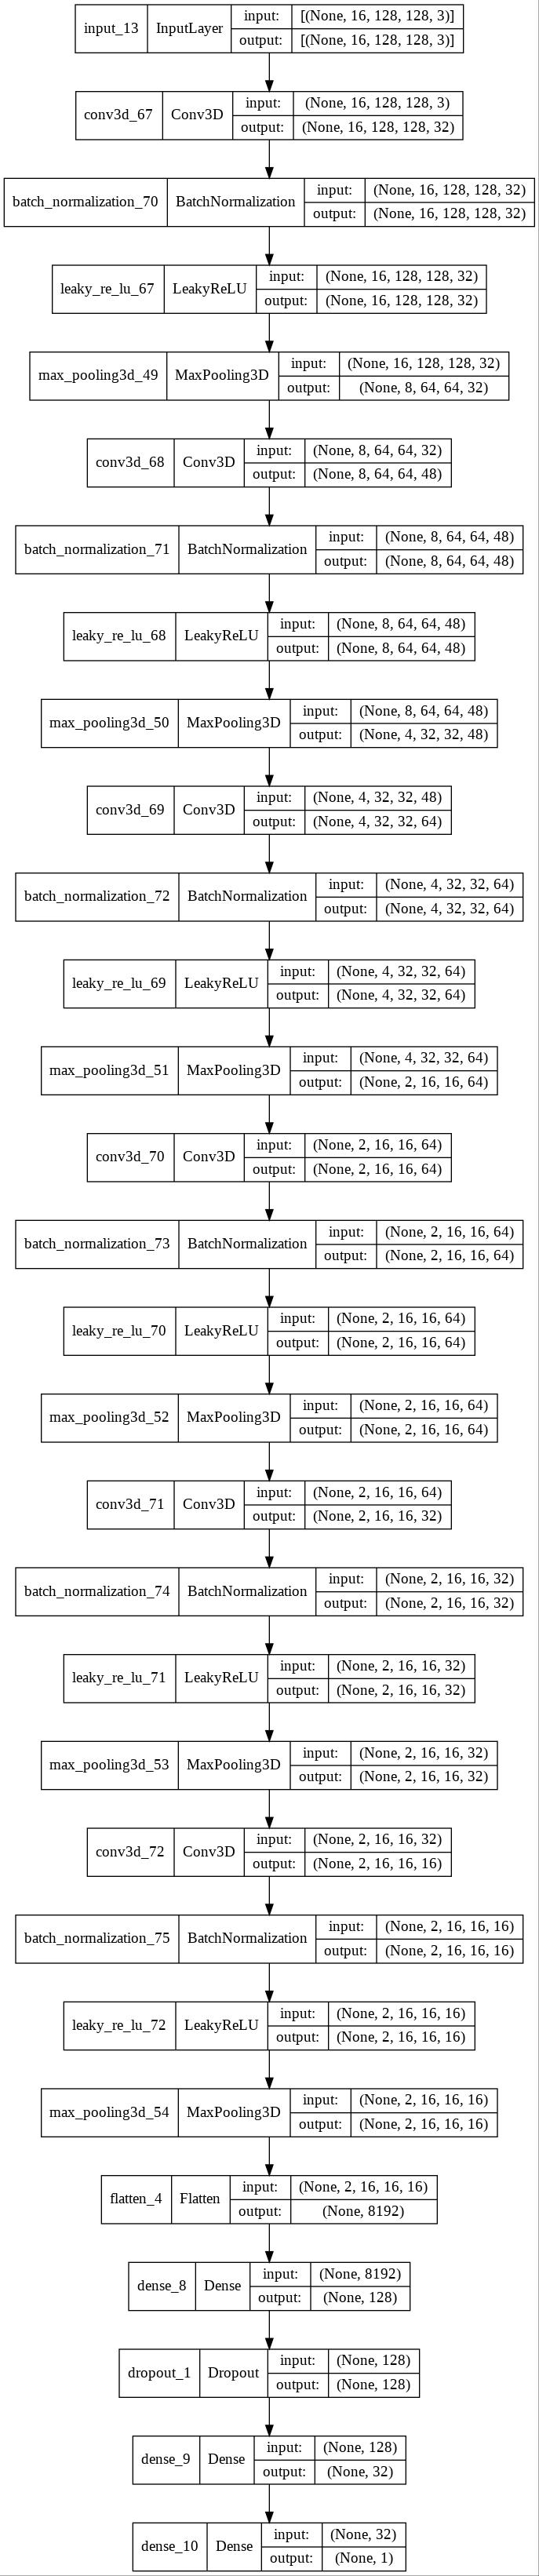

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(discriminator, to_file='gan_discriminator_plot.jpg', show_shapes=True, show_layer_names=True)

In [38]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def create_classifier_model(ecoded):

    X = Conv3D(filters=32, kernel_size=5, padding="same", name="classifier_layer")(ecoded)
    X = MaxPool3D(pool_size=2)(X)

    X = Conv3D(filters=16, kernel_size=3, padding="same")(X)
    
    X = Conv3D(filters=8, kernel_size=2, padding="same")(X)
              
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(8, activation='softmax')(X)
        
    return X

encoded = encoder(X_input)
classifier = Model(X_input,create_classifier_model(encoded))
opt = keras.optimizers.Adam()
loss = SparseCategoricalCrossentropy()
classifier.compile(loss=loss,
                   optimizer=opt,
                   metrics=['accuracy'])
print(classifier.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 16, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d_73 (Conv3D)          (None, 16, 128, 128, 32)  2624      
                                                                 
 batch_normalization_76 (Bat  (None, 16, 128, 128, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_73 (LeakyReLU)  (None, 16, 128, 128, 32)  0         
                                                                 
 max_pooling3d_55 (MaxPoolin  (None, 8, 64, 64, 32)    0         
 g3D)                                                            
                                                           

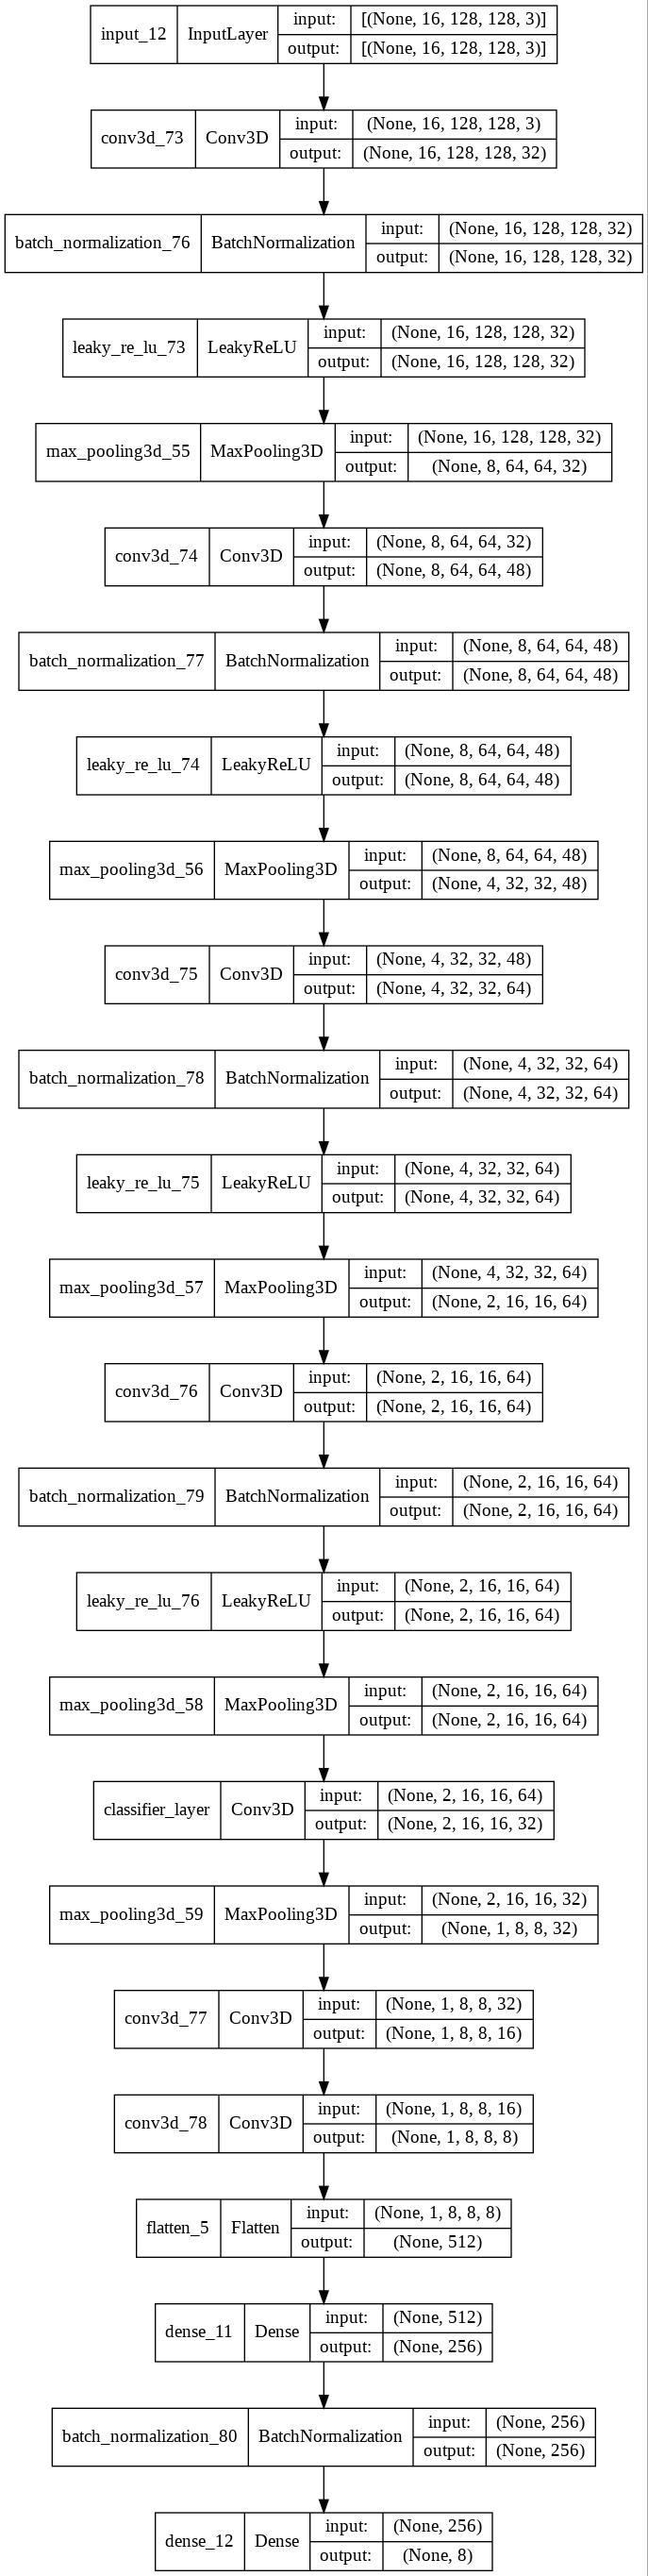

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='gan_classifier_plot.jpg', show_shapes=True, show_layer_names=True)